# Курсовой проект

### Постановка задачи
#### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

* course_project_train.csv - обучающий датасет
* course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

#### Подключение библиотек

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

#### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

#### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [8]:
print('Строк в train:', train_df.shape[0])
print('Столбцов в train', train_df.shape[1])
print('Строк в test', test_df.shape[0])
print('Столбцов в test', test_df.shape[1])

Строк в train: 7500
Столбцов в train 17
Строк в test 2500
Столбцов в test 16


#### Оптимизация данных

In [22]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    df_copy = df.copy()
    start_mem = df_copy.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df_copy.columns:
        col_type = df_copy[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df_copy[col] = df_copy[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df_copy[col] = df_copy[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df_copy[col] = df_copy[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df_copy[col] = df_copy[col].astype(np.int64)  
        else:
            df_copy[col] = df_copy[col].astype('category')

    end_mem = df_copy.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df_copy

In [23]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.72 MB
Decreased by 25.6%


In [24]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.24 MB
Decreased by 21.4%


#### Анализ данных

* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич

In [26]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float64
Years in current job            category
Tax Liens                        float64
Number of Open Accounts          float64
Years of Credit History          float64
Maximum Open Credit              float64
Number of Credit Problems        float64
Months since last delinquent     float64
Bankruptcies                     float64
Purpose                         category
Term                            category
Current Loan Amount              float64
Current Credit Balance           float64
Monthly Debt                     float64
Credit Score                     float64
Credit Default                      int8
dtype: object

#### Анализ целевой переменной "Credit Default"

c:\venv\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


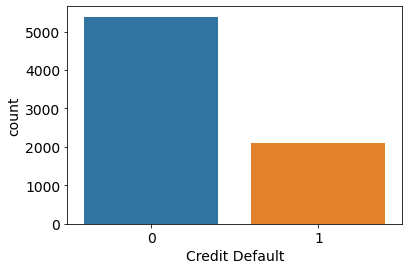

In [30]:
g = sns.countplot(train_df['Credit Default'])
plt.show ()

**Вывод:** Наблюдается Дисбаланс классов